# Hyperparameters and lags: backtesting vs one-step-ahead

In [79]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

In [85]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from copy import copy
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [95]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def grid_search_benchmark(
    data,
    forecaster_to_benchmark,
    lags_grid,
    param_grid,
    end_train,
    end_validation,
    target,
    exog_features,
    steps,
    plot = False
):
    """
    Compare results of grid search using backtesting and one step ahead.
    """
    
    # Method: backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    results_1 = grid_search_forecaster(
                forecaster         = forecaster,
                y                  = data.loc[:end_validation, target],
                exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                param_grid         = param_grid,
                lags_grid          = lags_grid,
                steps              = steps,
                refit              = False,
                metric             = ['mean_squared_error', 'mean_absolute_error'],
                initial_train_size = len(data.loc[:end_train]),
                method             = 'backtesting',
                fixed_train_size   = False,
                return_best        = True,
                n_jobs             = 'auto',
                verbose            = False,
                show_progress      = True
            )
    end = time()
    time_1 = end - start
    metric_1, predictions_1 = backtesting_forecaster(
        forecaster          = forecaster,
        y                   = data.loc[:, target],
        exog                = data.loc[:, exog_features] if exog_features else None,
        initial_train_size  = len(data.loc[:end_validation]),
        steps               = steps,
        metric              = 'mean_absolute_error',
        verbose             = False,
        show_progress       = False
    )

    # Method: one step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    results_2 = grid_search_forecaster(
                forecaster         = forecaster,
                y                  = data.loc[:end_validation, target],
                exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                param_grid         = param_grid,
                lags_grid          = lags_grid,
                steps              = steps,
                refit              = False,
                metric             = ['mean_squared_error', 'mean_absolute_error'],
                initial_train_size = len(data.loc[:end_train]),
                method             = 'one_step_ahead',
                fixed_train_size   = False,
                return_best        = True,
                n_jobs             = 'auto',
                verbose            = False,
                show_progress      = True
            )
    end = time()
    time_2 = end - start
    metric_2, predictions_2 = backtesting_forecaster(
        forecaster          = forecaster,
        y                   = data.loc[:, target],
        exog                = data.loc[:, exog_features] if exog_features else None,
        initial_train_size  = len(data.loc[:end_validation]),
        steps               = steps,
        metric              = 'mean_absolute_error',
        verbose             = False,
        show_progress       = False
    )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"lags   : {results_1.loc[0, 'lags']}")
    print(f"params : {results_1.loc[0, 'params']}")
    print(f"metrics: {metric_1.loc[0, 'mean_absolute_error']}")
    print("")
    print("Method: one step ahead")
    print(f"lags   : {results_2.loc[0, 'lags']}")
    print(f"params : {results_2.loc[0, 'params']}")
    print(f"metrics: {metric_2.loc[0, 'mean_absolute_error']}")

    if plot:
        fig, ax = plt.subplots(figsize=(9, 4))
        predictions_1['pred'].plot(ax=ax, label='backtesting')
        predictions_2['pred'].plot(ax=ax, label='one step ahead')
        data.loc[predictions_1.index, target].plot(ax=ax, label='data', color='black', linestyle='--')
        ax.legend()
        plt.show()
    
    return


def bayesian_search_benchmark(
    data,
    forecaster_to_benchmark,
    search_space,
    end_train,
    end_validation,
    target,
    exog_features,
    steps
):
    """
    Compare results of bayesian search using backtesting and one step ahead.
    """

    # Method: backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    results_1, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 20,
                        random_state       = 123,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )
    end = time()
    time_1 = end - start
    metric_1, predictions_1 = backtesting_forecaster(
        forecaster          = forecaster,
        y                   = data.loc[:, target],
        exog                = data.loc[:, exog_features] if exog_features else None,
        initial_train_size  = len(data.loc[:end_validation]),
        steps               = steps,
        metric              = 'mean_absolute_error',
        verbose             = False,
        show_progress       = False
    )

    # Method: one step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    results_2, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        fixed_train_size   = False,
                        n_trials           = 20,
                        random_state       = 123,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = True
                    )
    end = time()
    time_2 = end - start
    metric_2, predictions_2 = backtesting_forecaster(
        forecaster          = forecaster,
        y                   = data.loc[:, target],
        exog                = data.loc[:, exog_features] if exog_features else None,
        initial_train_size  = len(data.loc[:end_validation]),
        steps               = steps,
        metric              = 'mean_absolute_error',
        verbose             = False,
        show_progress       = False
    )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"lags   : {results_1.loc[0, 'lags']}")
    print(f"params : {results_1.loc[0, 'params']}")
    print(f"metrics: {metric_1.loc[0, 'mean_absolute_error']}")
    print("")
    print("Method: one step ahead")
    print(f"lags   : {results_2.loc[0, 'lags']}")
    print(f"params : {results_2.loc[0, 'params']}")
    print(f"metrics: {metric_2.loc[0, 'mean_absolute_error']}")

    if plot:
        fig, ax = plt.subplots(figsize=(9, 4))
        predictions_1['pred'].plot(ax=ax, label='backtesting')
        predictions_2['pred'].plot(ax=ax, label='one step ahead')
        data.loc[predictions_1.index, target].plot(ax=ax, label='data', color='black', linestyle='--')
        ax.legend()
        plt.show()

    return

## Forecaster Autoreg

### Benchmark: H2O dataset

In [96]:
# Data
# ==============================================================================
data = fetch_dataset(
    name="h2o",
    raw=True,
    kwargs_read_csv={"names": ["y", "datetime"], "header": 0},
    verbose=False,
)
data["datetime"] = pd.to_datetime(data["datetime"], format="%Y-%m-%d")
data = data.set_index("datetime")
data = data.asfreq("MS")
data = data[["y"]]
data = data.sort_index()
end_train = "2001-01-01 23:59:00"
end_validation = "2006-01-01 23:59:00"

In [97]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, verbose=-1),
                lags      = 10
            )
lags_grid = [3, 10, [1, 2, 3, 20]]
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 5]
}

grid_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'y',
    exog_features           = None,
    steps                   = 12
)

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'max_depth': 2, 'n_estimators': 100}
  Backtesting metric: 0.043298239712353144



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.04036612665139068

Benchmark results
-----------------
Execution time backtesting   : 1.0646412372589111
Execution time one step ahead: 0.23961329460144043
Same lags  : True
Same params: False

Method: backtesting
lags   : [ 1  2  3 20]
params : {'max_depth': 2, 'n_estimators': 100}
metrics: 0.22615930424513603

Method: one step ahead
lags   : [ 1  2  3 20]
params : {'max_depth': 5, 'n_estimators': 100}
metrics: 0.19334719207107526


### Benchmark: Bike sharing dataset

In [98]:
# Data
# ==============================================================================
data = fetch_dataset('bike_sharing_extended_features', verbose=False)
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]
exog_features = [
    'month_sin', 
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'temp',
    'holiday'
]

Number of models compared: 81.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 9279.38534985994



lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 200}
  Backtesting metric: 3642.69283936318

Benchmark results
-----------------
Execution time backtesting   : 241.40838050842285
Execution time one step ahead: 17.38507103919983
Same lags  : False
Same params: False

Method: backtesting
lags   : [  1   2   3  23  24  25 167 168 169]
params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
metrics: 57.17683746540067

Method: one step ahead
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
params : {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 200}
metrics: 67.28817019879422


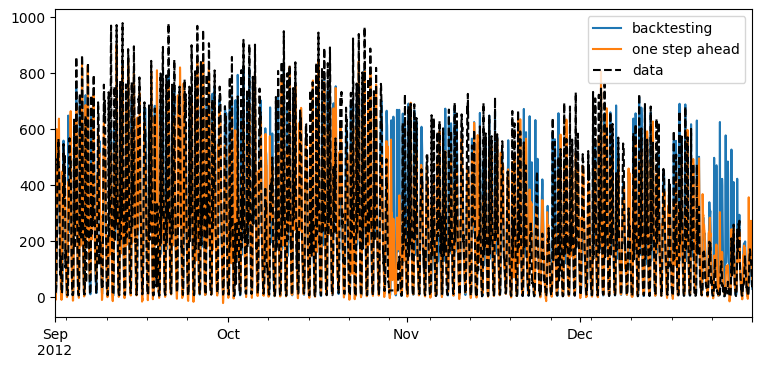

In [100]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.5]
}

grid_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 36
)

In [60]:
# Bayesian search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

bayesian_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 36
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.010416860203198298, 'subsample': 0.2755690967419942, 'colsample_bytree': 0.6560647401138757, 'gamma': 0.10155013994756559, 'reg_alpha': 0.8864717945956972, 'reg_lambda': 0.014015836934027859}
  Backtesting metric: 64.00591134157926



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:2184: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.022664761670265286, 'subsample': 0.11400878440779749, 'colsample_bytree': 0.9845292840882569, 'gamma': 0.004802254183477721, 'reg_alpha': 0.05556023765455381, 'reg_lambda': 0.22785658420818355}
  Backtesting metric: 43.1076403895807

Benchmark results
-----------------
Execution time backtesting   : 92.80150508880615
Execution time one step ahead: 31.722752809524536
Same lags  : True
Same params: False

Method: backtesting
lags   : [  1   2   3  23  24  25 167 168 169]
params : {'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.010416860203198298, 'subsample': 0.2755690967419942, 'colsample_bytree': 0.6560647401138757, 'gamma': 0.10155013994756559, 'reg_alpha': 0.8864717945956972, 'reg_lambda': 0.014015836934027859}
metrics: 54.63516407405189

Method: one step ahead
lags   

### Benchmark: website visits dataset

In [61]:
# Data
# ==============================================================================
data = fetch_dataset(name="website_visits", raw=True, verbose=False)
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%y')
data = data.set_index('date')
data = data.asfreq('1D')
data = data.sort_index()
data['month'] = data.index.month
data['month_day'] = data.index.day
data['week_day'] = data.index.day_of_week
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        ['month', 'week_day', 'month_day'],
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")
data = one_hot_encoder.fit_transform(data)
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]
exog_features = [col for col in data.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

In [62]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )
lags_grid = [7, 14, 21, [7, 14, 21]]
param_grid = {'alpha': np.logspace(-3, 3, 10)}

grid_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7
)

Number of models compared: 40.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 92723.37385771735



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1439: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.46415888336127775}
  Backtesting metric: 0.03135946751580578

Benchmark results
-----------------
Execution time backtesting   : 3.9025583267211914
Execution time one step ahead: 0.3029906749725342
Same lags  : True
Same params: False

Method: backtesting
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
params : {'alpha': 10.0}
metrics: 165.59443777438304

Method: one step ahead
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
params : {'alpha': 0.46415888336127775}
metrics: 170.6888738025913


In [63]:
# Bayesian search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )
lags_grid = [7, 14, 21, [7, 14, 21]]
def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

bayesian_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 1.2524531789882662}
  Backtesting metric: 224.33854613853265



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:2184: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 2.083580929967405}
  Backtesting metric: 0.13822004658108406

Benchmark results
-----------------
Execution time backtesting   : 2.1286542415618896
Execution time one step ahead: 0.3594093322753906
Same lags  : True
Same params: False

Method: backtesting
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
params : {'alpha': 1.2524531789882662}
metrics: 166.84400582475766

Method: one step ahead
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
params : {'alpha': 2.083580929967405}
metrics: 164.24239262308248


### Benchmark: electricity consumption dataset

In [64]:
# Data
# ==============================================================================
data = fetch_dataset(name='vic_electricity', raw=False, verbose=False)
data = data.drop(columns="Date")
data = (
    data
    .resample(rule="H", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()
exog_features = ['Temperature', 'Holiday']

/tmp/ipykernel_22955/1461443256.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(rule="H", closed="left", label="right")


In [65]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.5]
}

grid_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 36
)

Number of models compared: 81.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 94957.10876856494



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1439: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 9478.226436015197

Benchmark results
-----------------
Execution time backtesting   : 500.92502546310425
Execution time one step ahead: 19.019285917282104
Same lags  : True
Same params: True

Method: backtesting
lags   : [  1   2   3  23  24  25 167 168 169]
params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
metrics: 245.7862163569872

Method: one step ahead
lags   : [  1   2   3  23  24  25 167 168 169]
params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
metrics: 245.7862163569872


In [66]:
# Bayesian search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

bayesian_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 36
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.06908111764347266, 'subsample': 0.4582398297973883, 'colsample_bytree': 0.7641958651588321, 'gamma': 0.18249173045349998, 'reg_alpha': 0.17545175614749253, 'reg_lambda': 0.5315513738418384}
  Backtesting metric: 191.8626391693285



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:2184: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.05679576034204338, 'subsample': 0.10725502906361839, 'colsample_bytree': 0.9892976403836156, 'gamma': 0.006453374219829056, 'reg_alpha': 0.0038381442337546146, 'reg_lambda': 0.24053684218482807}
  Backtesting metric: 55.35922291628681

Benchmark results
-----------------
Execution time backtesting   : 168.10749125480652
Execution time one step ahead: 30.493957042694092
Same lags  : True
Same params: False

Method: backtesting
lags   : [  1   2   3  23  24  25 167 168 169]
params : {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.06908111764347266, 'subsample': 0.4582398297973883, 'colsample_bytree': 0.7641958651588321, 'gamma': 0.18249173045349998, 'reg_alpha': 0.17545175614749253, 'reg_lambda': 0.5315513738418384}
metrics: 231.47139120775364

Method: one step ahead
lags 

## Forecaster AutoregDirect

In [68]:
# Data
# ==============================================================================
data = fetch_dataset('bike_sharing_extended_features', verbose=False)
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]
exog_features = [
    'month_sin', 
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'temp',
    'holiday'
]

# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 5,
                 lags      = 10
             )
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]
param_grid = {'alpha': np.logspace(-3, 3, 10)}

grid_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 5
)

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'alpha': 1000.0}
  Backtesting metric: 10439.128519885262



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1439: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'alpha': 46.41588833612773}
  Backtesting metric: 43422.71251085582

Benchmark results
-----------------
Execution time backtesting   : 68.23288369178772
Execution time one step ahead: 2.785736083984375
Same lags  : False
Same params: False

Method: backtesting
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
params : {'alpha': 1000.0}
metrics: 67.37528369177734

Method: one step ahead
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
params : {'alph

In [69]:
# Bayesian search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 5,
                 lags      = 10
             )
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]
def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

bayesian_search_benchmark(
    data                    = data,
    forecaster_to_benchmark = forecaster,
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 5
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'alpha': 925.1006260111275}
  Backtesting metric: 70.99353356420917



/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:2184: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'alpha': 6.403328042606579}
  Backtesting metric: 149.21303984528487

Benchmark results
-----------------
Execution time backtesting   : 46.042985677719116
Execution time one step ahead: 2.3074543476104736
Same lags  : False
Same params: False

Method: backtesting
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
params : {'alpha': 925.1006260111275}
metrics: 67.37630319670156

Method: one step ahead
lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
p